# Diabetic Retinopathy Detection With AI

### Project Certificate link : "https://www.coursera.org/learn/retinopathy-detection-using-deep-learning'

## TASK #1: UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

![Description](./images/intro.png)

Google and Aravind Eye Hospital work: https://venturebeat.com/2019/02/25/google-works-with-aravind-eye-hospital-to-deploy-ai-that-can-detect-eye-disease/

Data Source: https://www.kaggle.athy-detectioncom/c/diabetic-retinopathy-detection

## Instructor :
https://www.coursera.org/instructor/~48777395

![Description](./images/instructor.png)

![Description](./images/inp.png)

## TASK #2: IMPORT LIBRARIES/DATASETS

In [17]:
# Import the necessary packages

import pandas as pd #dataframe manipulation
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns #data visualisation
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from plotly.offline import iplot, init_notebook_mode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [18]:
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
# setting the style of the notebook to be monokai theme
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them (as in vscode).

In [19]:
# import os
# print(os.listdir('/kaggle/input/'))

In [20]:
# os.listdir(os.path.join('/kaggle/input/train', 'Mild'))

In [21]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('/kaggle/input/train'):
  print(i)
  train_class = os.listdir(os.path.join('/kaggle/input/train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))

Mild
Proliferate_DR
Moderate
No_DR
Severe
Number of train images : 3662 



In [22]:
train
print(len(train))

3662


In [ ]:
label

Print out the count plot for all classes using Seaborn (External Research is Required)
sns.countplot(label)

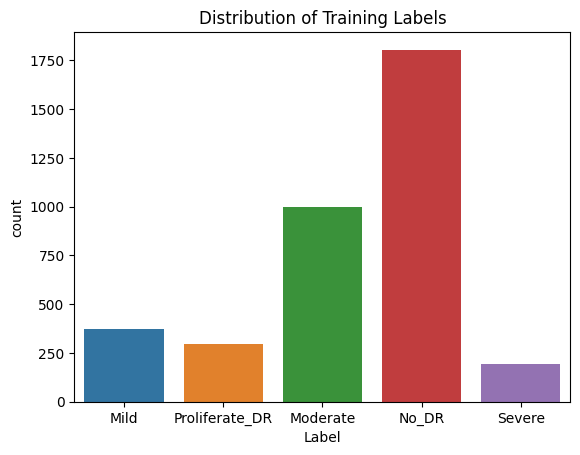

In [24]:
label_series = pd.Series(label, name="Label")
sns.countplot(x=label_series)
plt.title("Distribution of Training Labels")
plt.show()

## TASK #3: PERFORM DATA EXPLORATION AND DATA VISUALIZATION

Has to add preprocessing

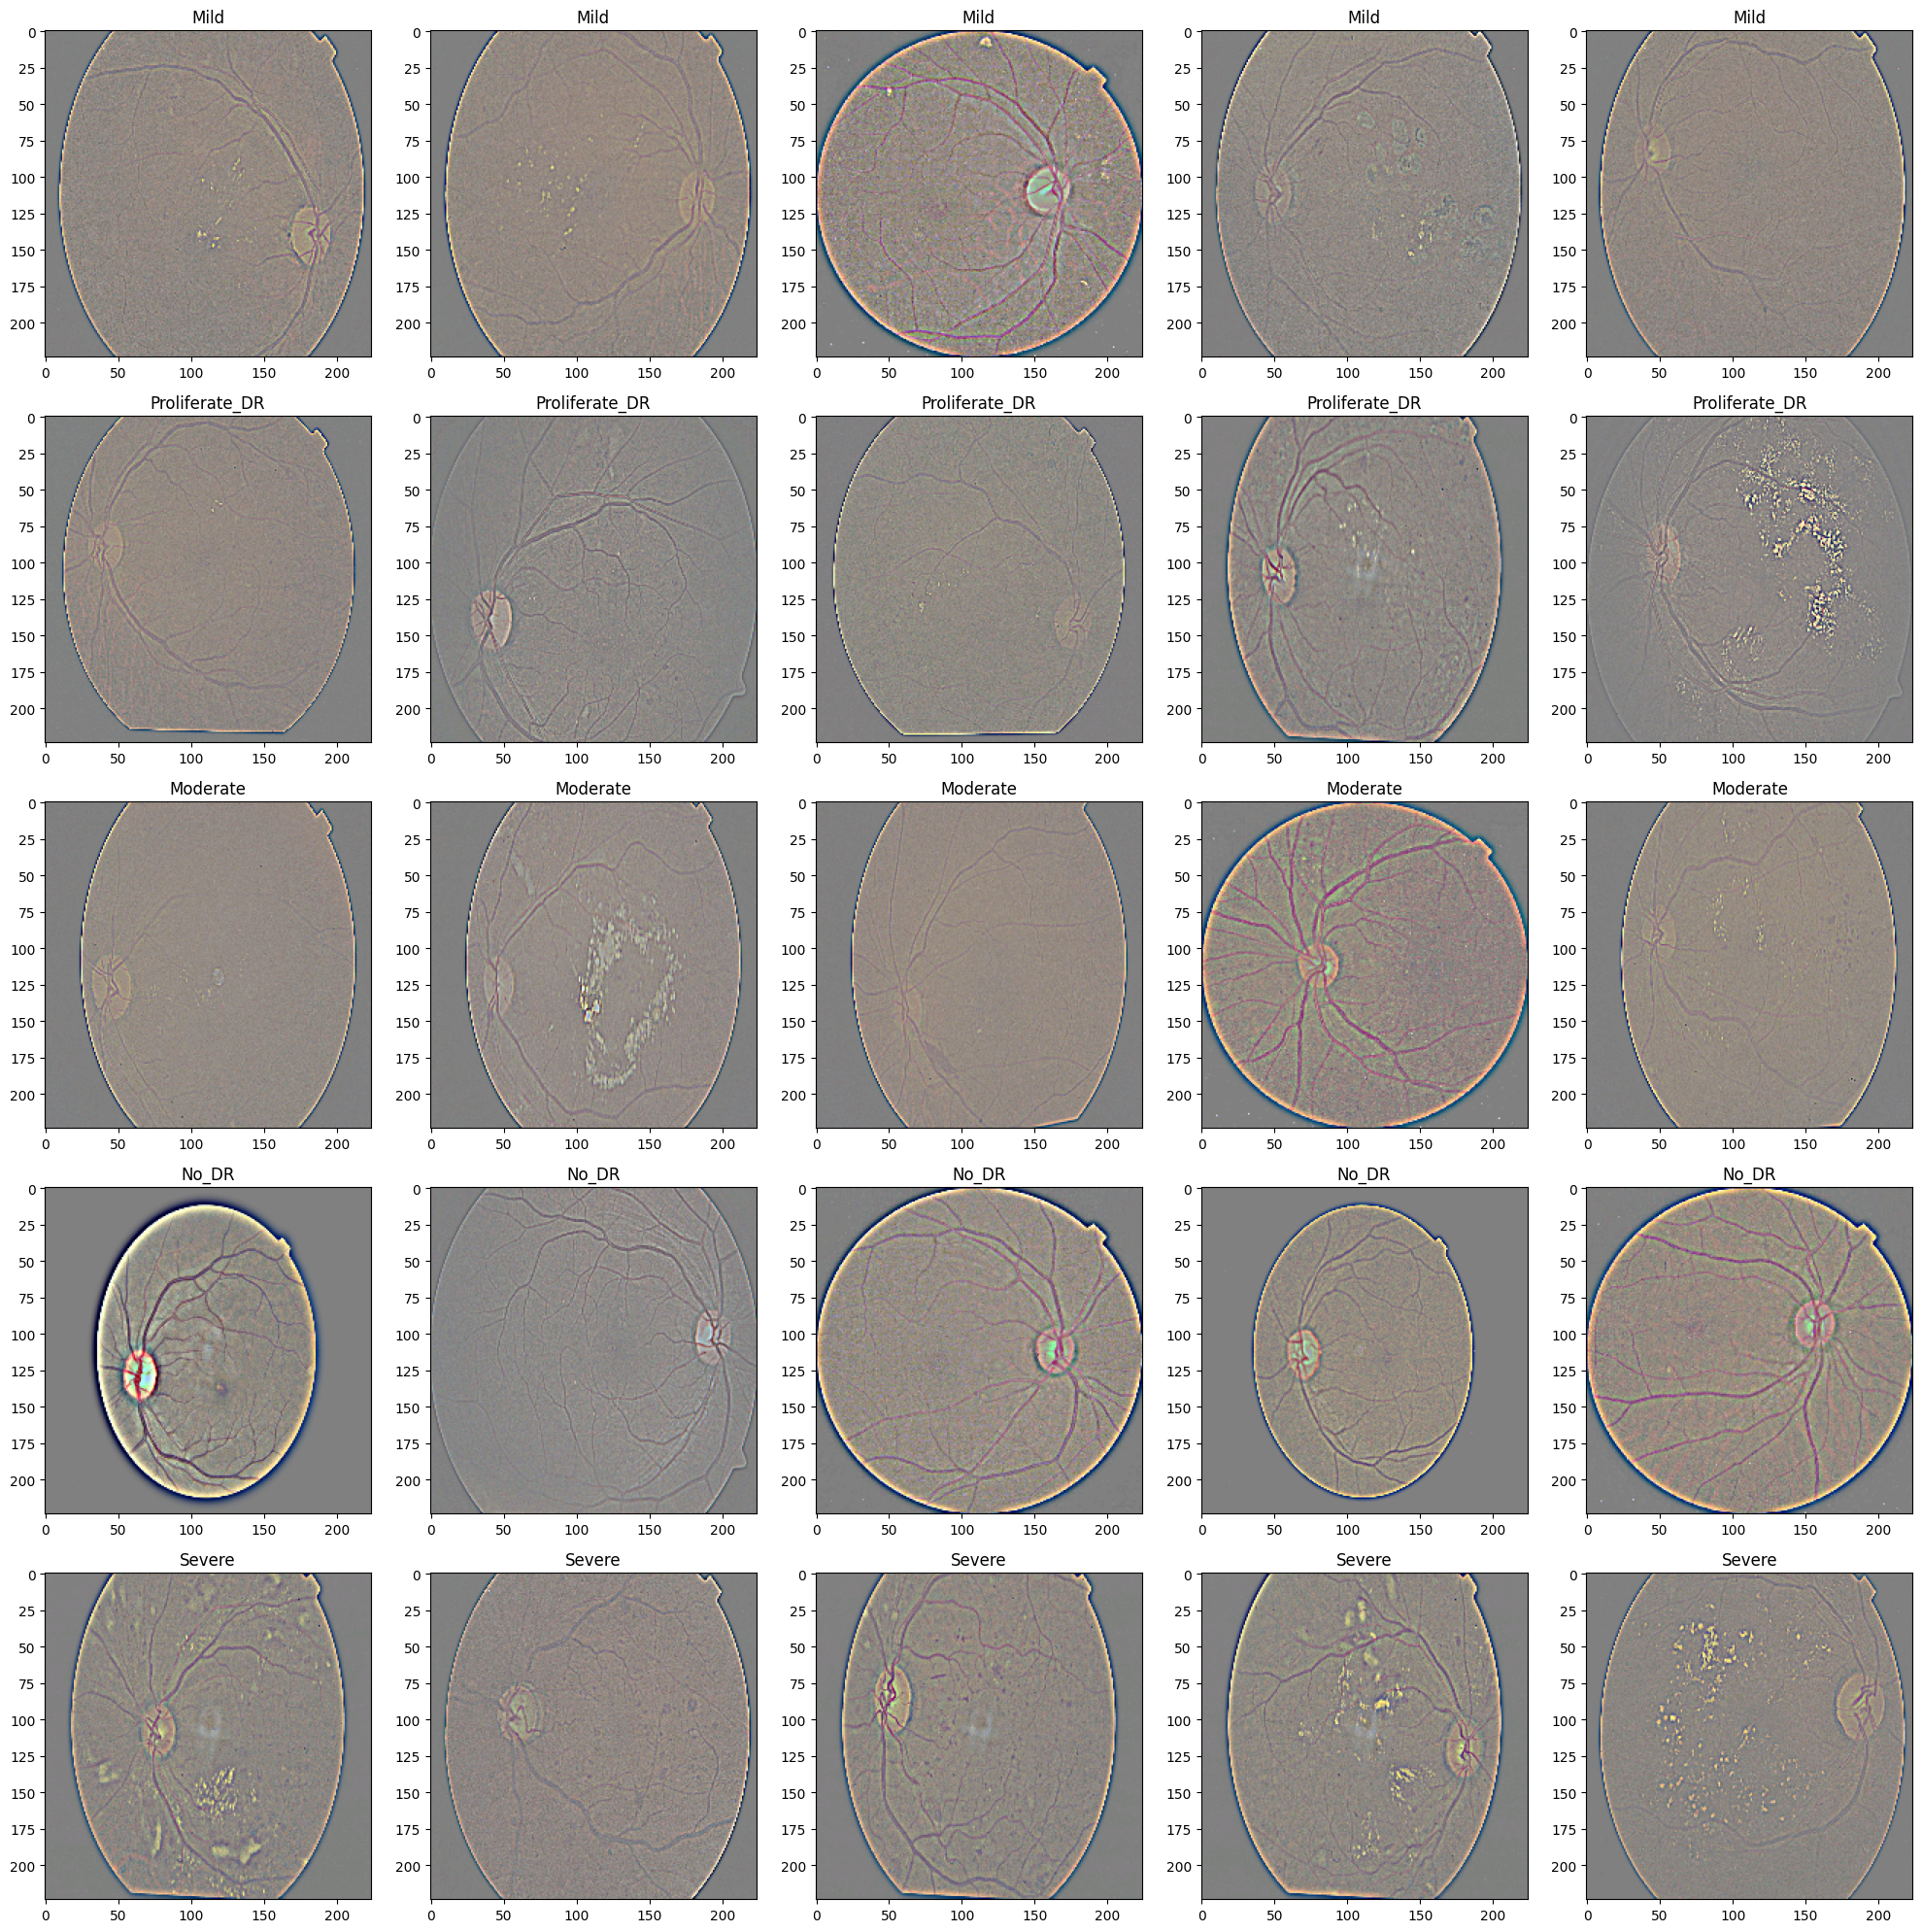

In [25]:
# Visualize 5 images for each class in the dataset

fig, axs = plt.subplots(5, 5, figsize = (20, 20))
count = 0
for i in os.listdir('/kaggle/input/train'):
  # get the list of images in a given class
  train_class = os.listdir(os.path.join('/kaggle/input/train', i))
  # plot 5 images per class
  for j in range(5):
    img = os.path.join('/kaggle/input/train', i, train_class[j])
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)
  count += 1

fig.tight_layout()

In [26]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('/kaggle/input/train'):
  train_class = os.listdir(os.path.join('/kaggle/input/train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Proliferate_DR = 295 

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Severe = 193 



In [27]:

base_path = '/kaggle/input'
# Your preprocessing functions
def circle_crop(image):
    rows, cols = image.shape[:2]
    mask = np.zeros((rows, cols), dtype=np.uint8)
    center = (cols // 2, rows // 2)
    radius = min(center[0], center[1])
    cv2.circle(mask, center, radius, (255), thickness=-1)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

def median_subtraction(image):
    median = np.median(image)
    return image - median

# def gamma_correction(image, gamma=1.0):
#     look_up_table = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype("uint8")
#     return cv2.LUT(image, look_up_table)

def gamma_correction(image, gamma=1.0):
    # Ensure the image is in 8-bit format
    image = cv2.convertScaleAbs(image)  # Converts to 8-bit image
    
    look_up_table = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, look_up_table)

def adaptive_histogram_equalization(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    equalized_image = clahe.apply(gray_image)
    return equalized_image

# Preprocessing pipeline
def preprocess_image(image_path, gamma=1.0):
    # Load image from path
    image = cv2.imread(os.path.join(base_path,image_path))
    # cv2.imshow('Image', image)
    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    # plt.axis('off')  # Hide axes
    # plt.show()
    # Apply all preprocessing steps
    circled_image = circle_crop(image)
    median_subtracted_image = median_subtraction(circled_image)
    gamma_corrected_image = gamma_correction(median_subtracted_image, gamma)
    final_image = adaptive_histogram_equalization(gamma_corrected_image)
    
    return final_image

# Apply preprocessing to the entire dataframe
def preprocess_dataframe(df):
    processed_images = []
    for img_path in df['Image']:
        # Apply preprocessing pipeline to each image
        preprocessed_img = preprocess_image(img_path)
        processed_images.append(preprocessed_img)
    return processed_images




In [28]:
# print(train.head())
# print(len(label))
import cv2

                         Image Labels
0  train/Mild/f481f76a6b75.png   Mild
1  train/Mild/abdb365cacbc.png   Mild
2  train/Mild/33ffddea8c6e.png   Mild
3  train/Mild/059bc89df7f4.png   Mild
4  train/Mild/278aa860dffd.png   Mild


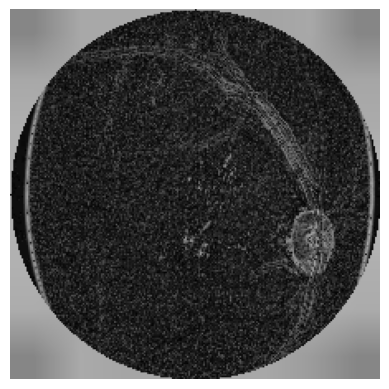

                                               Image Labels
0  [[134, 134, 134, 134, 134, 134, 134, 134, 134,...   Mild
1  [[134, 134, 134, 134, 134, 134, 134, 134, 134,...   Mild
2  [[137, 137, 137, 137, 137, 137, 137, 137, 137,...   Mild
3  [[135, 135, 135, 135, 135, 135, 135, 135, 135,...   Mild
4  [[134, 134, 134, 134, 134, 134, 134, 134, 134,...   Mild


In [29]:
# Create your DataFrame
retina_df = pd.DataFrame({'Image': train,'Labels': label})

print(retina_df.head())
# retina_df = pd.DataFrame({'Image': train, 'Labels': label})

# Preprocess the images
processed_images = preprocess_dataframe(retina_df)

# Now, you can either add these processed images to your dataframe or directly use them for model training
retina_df['Image'] = processed_images

# Example: Plotting first image from the dataframe to visualize the result
plt.imshow(cv2.cvtColor(retina_df['Image'][0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Print out first few rows to check the processed images
print(retina_df.head())

Plot a pie chart showing the percentage of samples per class.

<function matplotlib.pyplot.show(close=None, block=None)>

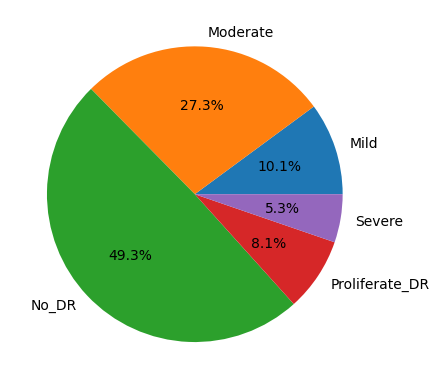

In [30]:
No_images_per_class = [370,999,1805,295,193]
Class_name = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
fig1, ax1 = plt.subplots()
ax1.pie(No_images_per_class, labels = Class_name, autopct = '%1.1f%%')
plt.show

## TASK #4: PERFORM DATA AUGMENTATION AND CREATE DATA GENERATOR

In [31]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.2)
print(train['Image'].head())
# 0.2 means 20% for testing and 80% for training
# base_path = '/kaggle/input'
# train['Image'] = train['Image'].apply(lambda x: os.path.join(base_path, x))
# test['Image'] = test['Image'].apply(lambda x: os.path.join(base_path, x))
# print("Current working directory:", os.getcwd())
# missing_files = [path for path in train['Image'] if not os.path.exists(path)]
# count=0
# if missing_files:
#     # count+=1
#     print(f"Missing files: {missing_files}")  # Print first 5 missing files
# else:
#     print("All files exist.")
# print(count)

570     [[131, 131, 131, 131, 131, 131, 131, 131, 131,...
2079    [[137, 137, 137, 137, 137, 137, 137, 137, 137,...
1832    [[131, 131, 131, 131, 131, 131, 131, 131, 131,...
433     [[131, 131, 131, 131, 131, 131, 131, 131, 131,...
3249    [[132, 132, 132, 132, 132, 132, 132, 132, 132,...
Name: Image, dtype: object


Normal augmentation !!!!!!!!!!!!! need to change it.

In [32]:
# Create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range and horizontal flip
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        validation_split = 0.15)

# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)
# print(train_datagen)
# print(test_datagen)

In [33]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.utils import Sequence
# import numpy as np
# import os

# class CustomImageDataGenerator(Sequence):
#     def __init__(self, dataframe, directory, x_col, y_col, batch_size, target_size, class_mode='categorical', shuffle=True):
#         self.dataframe = dataframe
#         self.directory = directory
#         self.x_col = x_col
#         self.y_col = y_col
#         self.batch_size = batch_size
#         self.target_size = target_size
#         self.class_mode = class_mode
#         self.shuffle = shuffle
#         self.indexes = np.arange(len(self.dataframe))  # To shuffle or cycle through data
        
#     def __len__(self):
#         return int(np.floor(len(self.dataframe) / self.batch_size))
    
#     def __getitem__(self, index):
#         # Select batch indices
#         batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_data = self.dataframe.iloc[batch_indexes]
        
#         # Load images and convert them to arrays
#         images = []
#         for img_name in batch_data[self.x_col]:
#             img_path = os.path.join(self.directory, img_name)
#             img = load_img(img_path, target_size=self.target_size)
#             img_array = img_to_array(img)  # Convert image to numpy array
#             images.append(img_array)
        
#         # Convert to numpy array and normalize
#         images = np.array(images)
#         images = images / 255.0  # Normalization (optional)
        
#         # Get labels
#         labels = batch_data[self.y_col].values
#         if self.class_mode == 'categorical':
#             labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.dataframe[self.y_col].unique()))
        
#         return images, labels
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indexes)  # Shuffle data at the end of each epoch

#     def __iter__(self):
#         return iter(super().flow_from_dataframe(...)) 


In [34]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.utils import Sequence
# import numpy as np
# import os
# import tensorflow as tf

# class CustomImageDataGenerator(Sequence):
#     def __init__(self, dataframe, directory, x_col, y_col, batch_size, target_size, class_mode='categorical', shuffle=True):
#         self.dataframe = dataframe
#         self.directory = directory
#         self.x_col = x_col
#         self.y_col = y_col
#         self.batch_size = batch_size
#         self.target_size = target_size
#         self.class_mode = class_mode
#         self.shuffle = shuffle
#         self.indexes = np.arange(len(self.dataframe))  # Initialize indexes to shuffle or cycle through data
        
#     def __len__(self):
#         # Number of batches per epoch
#         return int(np.floor(len(self.dataframe) / self.batch_size))
    
#     def __getitem__(self, index):
#         # Select batch indices
#         batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_data = self.dataframe.iloc[batch_indexes]  # Using iloc to get rows for the batch
        
#         # Load images and convert them to arrays
#         images = []
#         for img_name in batch_data[self.x_col]:
#             img_path = os.path.join(self.directory, img_name)  # Full image path
#             img = load_img(img_path, target_size=self.target_size)  # Load and resize image
#             img_array = img_to_array(img)  # Convert image to numpy array
#             images.append(img_array)
        
#         # Convert images list to numpy array and normalize
#         images = np.array(images)
#         images = images / 255.0  # Normalize pixel values to [0, 1]
        
#         # Get labels
#         labels = batch_data[self.y_col].values
#         if self.class_mode == 'categorical':
#             labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.dataframe[self.y_col].unique()))  # One-hot encoding
        
#         return images, labels
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indexes)  # Shuffle data at the end of each epoch

#     # No need to define __iter__ here, as the generator already works with Sequence.


In [36]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import pandas as pd
import tensorflow as tf

class CustomImageDataGenerator(Sequence):
    def __init__(self, dataframe, directory, x_col, y_col, batch_size, target_size, class_mode='categorical', shuffle=True):
        # Ensure the dataframe is a pandas DataFrame
        if isinstance(dataframe, list):
            print("Converting list to DataFrame")
            self.dataframe = pd.DataFrame(dataframe)  # Convert list to DataFrame if needed
        elif isinstance(dataframe, pd.DataFrame):
            self.dataframe = dataframe  # Directly assign if it's already a DataFrame
        else:
            raise ValueError("The dataframe is neither a list nor a pandas DataFrame.")
        
        print(f"Dataframe type: {type(self.dataframe)}")  # Debug print
        
        self.directory = directory
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))  # Initialize indexes to shuffle or cycle through data
        
    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.dataframe) / self.batch_size))
    
    
        
    
        

    def __getitem__(self, index):
        # Select batch indices
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Get batch data
        batch_data = self.dataframe.iloc[batch_indexes]
        
        # Prepare images
        images = []
        for img_name in batch_data[self.x_col]:
            if isinstance(img_name, np.ndarray):  # If it's pixel data
                if img_name.ndim == 2:  # Grayscale
                    img_name = np.expand_dims(img_name, axis=-1)  # Add channel dimension
                    img_name = np.repeat(img_name, 3, axis=-1)  # Convert to RGB by repeating channels
                if img_name.shape[:2] != self.target_size:
                    img_name = tf.image.resize(img_name, self.target_size).numpy()
                images.append(img_name)
            else:
                img_name = str(img_name)  # Ensure it's a string
                if not img_name.endswith(('.jpg', '.png', '.jpeg')):
                    raise ValueError(f"Invalid image filename: {img_name}")
                img_path = os.path.join(self.directory, img_name)
                try:
                    img = load_img(img_path, target_size=self.target_size, color_mode='rgb')  # Force RGB
                    img_array = img_to_array(img)
                    images.append(img_array)
                except FileNotFoundError:
                    raise FileNotFoundError(f"Image file not found: {img_path}")
        
        # Convert images list to numpy array and normalize
        images = np.array(images)
        images = images / 255.0  # Normalize to [0, 1]
        
        # Prepare labels
        labels = batch_data[self.y_col].values
        if self.class_mode == 'categorical':
            # Map string labels to integers
            unique_labels = self.dataframe[self.y_col].unique()
            label_map = {label: idx for idx, label in enumerate(unique_labels)}
            labels = np.array([label_map[label] for label in labels])
            
            # One-hot encode labels
            labels = tf.keras.utils.to_categorical(labels, num_classes=len(unique_labels))
        
        return images, labels



    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)  # Shuffle data at the end of each epoch


In [37]:
# Creating datagenerator for training, validation and test dataset.

train_generator = CustomImageDataGenerator(
    dataframe=train,
    directory='/kaggle/input/images',  # Update the directory if necessary
    x_col='Image',  # This column should contain image file names
    y_col='Labels',
    batch_size=32,
    target_size=(256, 256),
    class_mode='categorical',
    shuffle=True
)




validation_generator = CustomImageDataGenerator(
    dataframe=train,
    directory='/kaggle/input/images',  # Update the directory if necessary
    x_col='Image',
    y_col='Labels',
    batch_size=32,
    target_size=(256, 256),
    class_mode='categorical',
    shuffle=False
)

test_generator = CustomImageDataGenerator(
    dataframe=test,
    directory='/kaggle/input/images',  # Update with the correct directory
    x_col='Image',  # This column should contain image file names
    y_col='Labels',
    batch_size=32,
    target_size=(256, 256),
    class_mode='categorical',
    shuffle=False  # No shuffling for test data
)

Dataframe type: <class 'pandas.core.frame.DataFrame'>
Dataframe type: <class 'pandas.core.frame.DataFrame'>
Dataframe type: <class 'pandas.core.frame.DataFrame'>


In [38]:
# print(train_generator.filepaths[:5])  # Print first 5 filepaths from train_generator
# print(validation_generator.filepaths[:5])  # Print first 5 filepaths from validation_generator


Experiment with other image augmentation strategies to the training data. We can pick any one augmentation strategy.

HINT: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [39]:
tf.keras.preprocessing.image.ImageDataGenerator(
      featurewise_center=False,
      samplewise_center=False,
      featurewise_std_normalization=False,
      samplewise_std_normalization=False,
      zca_whitening=False,
      zca_epsilon=1e-06,
      rotation_range=0,
      width_shift_range=0.0,
      height_shift_range=0.0,
      brightness_range=None,
      shear_range=0.0,
      zoom_range=0.0,
      channel_shift_range=0.0,
      fill_mode="nearest",
      cval=0.0,
      horizontal_flip=False,
      vertical_flip=False,
      rescale=None,
      preprocessing_function=None,
      data_format=None,
      validation_split=0.3,
      dtype=None)

## TASK #5: UNDERSTAND THE THEORY AND INTUITION BEHIND CONVOLUTIONAL NEURAL NETWORKS (CNN) AND RESIDUAL BLOCKS

![Description](./images/cnn.png)

### RESNET (RESIDUAL NETWORK)
- As CNNs grow deeper, vanishing gradient tend to occur which negatively impact network performance.
- Vanishing gradient problem occurs when the gradient is back-propagated to earlier layers
which results in a very small gradient.
- Residual Neural Network includes "skip connection" feature which enables training of 152 layers without vanishing gradient issues.
- Resnet works by adding "identity mappings" on top of the CNN.
ImageNet contains 11 million images and 11,000 categories. ImageNet is used to train Res- Net deep network.


![Example Image](https://upload.wikimedia.org/wikipedia/commons/5/59/Resnet.png)

![Description](./images/resmodel.png)

![Description](./images/conv.png)

## TASK #6: BUILD RES-BLOCK BASED DEEP LEARNING MODEL

In [40]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [41]:

input_shape = (256,256,3)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage

X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage

X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage

X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage

X = res_block(X, filter= [256,256,1024], stage= 4)

# # 5- stage

# X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling

X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 128, 128,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 128, 128,  │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_a        │ (None, 63, 63,    │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 31, 31,    │          0 │ res_2_conv_a[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_a         │ (None, 31, 31,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 31, 31,    │          0 │ bn_2_conv_a[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_b        │ (None, 31, 31,    │     36,928 │ activation_1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_b         │ (None, 31, 31,    │        256 │ res_2_conv_b[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 31, 31,    │          0 │ bn_2_conv_b[0][0] │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_copy     │ (None, 63, 63,    │     16,640 │ max_pooling2d[0]… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_2_conv_c        │ (None, 31, 31,    │     16,640 │ activation_2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 31, 31,    │          0 │ res_2_conv_copy[… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2_conv_c         │ (None, 31, 31,    │      1,024 │ res_2_conv_c[0][

 Total params: 4,987,525 (19.03 MB)

 Trainable params: 4,967,685 (18.95 MB)

 Non-trainable params: 19,840 (77.50 KB)

# TASK #7: COMPILE AND TRAIN DEEP LEARNING MODEL

In [42]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [43]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.keras", verbose=1, save_best_only=True)

In [44]:
# # Check if train_generator is yielding data
# # x_train, y_train = next(train_generator)
# # print(f"Train Input Shape: {x_train.shape}, Train Label Shape: {y_train.shape}")

# # # Check if validation_generator is yielding data
# # x_val, y_val = next(validation_generator)
# # print(f"Validation Input Shape: {x_val.shape}, Validation Label Shape: {y_val.shape}")

# # # Check if the train generator yields data correctly
# for x_train, y_train in train_generator:
#     print(f"Train Input Shape: {x_train.shape}, Train Label Shape: {y_train.shape}")
#     break  # Just one batch for inspection



In [ ]:
# Use train_generator to train the model
model.fit(train_generator, epochs=10, steps_per_epoch=len(train_generator))


Epoch 1/10


In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train_loss','val_loss'], loc = 'upper right')
# plt.show()

## TASK #8: ASSESS THE PERFORMANCE OF THE TRAINED MODEL

![Description](./images/conmat.png)

In [ ]:
# model.load_weights("weights.keras")
# print(os.listdir())

In [ ]:
# Evaluate the performance of the model
# evaluate = model.evaluate(test_generator, steps = test_generator.n // 32, verbose =1)
# Test the model using the test generator
steps = len(test_generator)  # or test_generator.samples // test_generator.batch_size

evaluate = model.evaluate(test_generator, steps=steps, verbose=1)

print('Accuracy Test : {}'.format(evaluate[1]))

In [ ]:
# Assigning label names to the corresponding indexes
labels = {0: 'Mild', 1: 'Moderate', 2: 'No_DR', 3:'Proliferate_DR', 4: 'Severe'}

In [ ]:
# Loading images and their predictions

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
from PIL import Image
# pip install opencv-python
prediction = []
original = []
image = []
count = 0

for item in range(len(test)):
  img_data = test['Image'].tolist()[item]  # Assuming this is a numpy array
    # If the image is grayscale, convert it to RGB
  if img_data.ndim == 2:  # Grayscale image
    img = Image.fromarray(img_data).convert('RGB')  # Convert to RGB
  else:  # RGB image
    img = Image.fromarray(img_data)
  # img = Image.fromarray(img_data)  # Convert numpy array to PIL Image
  # code to open the image
  # img= PIL.Image.open(test['Image'].tolist()[item])
  # resizing the image to (256,256)
  img = img.resize((256,256))
  # appending image to the image list
  image.append(img)
  # converting image to array
  img = np.asarray(img, dtype= np.float32)
  # normalizing the image
  img = img / 255
  # reshaping the image in to a 4D array
  if img.shape == (256, 256, 3):
    img = img.reshape(1, 256, 256, 3)  # Reshape to (1, 256, 256, 3) for batch prediction
  else:
    print(f"Unexpected image shape: {img.shape}")
  # making prediction of the model
  predict = model.predict(img)
  # getting the index corresponding to the highest value in the prediction
  predict = np.argmax(predict)
  # appending the predicted class to the list
  prediction.append(labels[predict])
  # appending original class to the list
  original.append(test['Labels'].tolist()[item])

In [ ]:
# Getting the test accuracy
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

In [ ]:
# Visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()


 - print out the classification report
 - print out the confusion matrix and comment on the model performance

In [ ]:
# Print out the classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))

In [ ]:

# plot the confusion matrix
plt.figure(figsize = (20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

## In this project, I learned the following objectives:

- Understand the theory and intuition behind Deep Neural Networks, Residual Nets, and Convolutional Neural Networks (CNNs).

- Apply Python libraries to import, pre-process and visualize images.

- Perform data augmentation to improve model generalization capability.

- Build a deep learning model based on Convolutional Neural Network and Residual blocks using Keras with Tensorflow 2.0 as a backend.

- Compile and fit Deep Learning model to training data.

- Assess the performance of trained CNN and ensure its generalization using various KPIs such as accuracy, precision and recall.